In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
from scipy.misc import factorial
from scipy.stats import beta
from scipy.stats import binom

In [3]:
# The number of impressions for our new ad campaign
n_impressions = 20
# The number of clicks for our new ad campaign
n_clicks = 14
# Observed click through rate
ctr = float(n_clicks) / n_impressions
print "CTR based on the new ad campaign: {} %".format(ctr * 100)

CTR based on the new ad campaign: 70.0 %


In [4]:
# 0 to 1, all possible click through rates
x = np.arange(0, 1, 0.01)

# Evaluate the likelihood function for possible click through rates
likelihood = binom.pmf(n_clicks, n_impressions, x)

In [5]:
# Pick the best theta (Maximum Likelihood Estimator)
mle = x[np.argmax(likelihood)]
print "MLE: {} %".format(mle * 100)

MLE: 70.0 %


In [6]:
# Randomly generate "true" click through rate (CTR) for each past campaign (1 in 5)
np.random.seed(42)
p = np.random.beta(10, 40, size=100)
# Randomly pick the number of impressions for each campaign
impressions = np.random.randint(1000, 10000, size=100)
# Randomly sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p)
# Calculate CTR for each past campaign
click_through_rates = clicks.astype(np.float) / impressions
print "Average past CTR: {} %".format(click_through_rates.mean() * 100)

Average past CTR: 20.0416384474 %


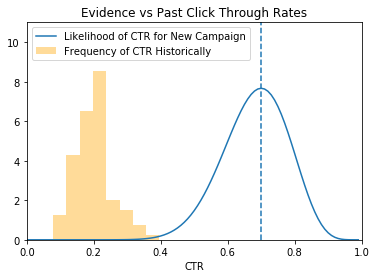

In [7]:
# Plot the histogram of previous click through rates with the evidence of the new campaign
f, ax = plt.subplots(1)
plt.axvline(mle, ls="--")
plt.plot(x, 40 * likelihood, label='Likelihood of CTR for New Campaign')
sns.distplot(click_through_rates, kde=False, bins=8,
             norm_hist=True, label='Frequency of CTR Historically', color='orange')
ax.legend()
ax.set_xlabel("CTR")
ax.set_title("Evidence vs Past Click Through Rates")
ax.set_ylim(0, 11)
ax.set_xlim(0, 1);

In [8]:
# Fit beta to previous CTRs
prior_parameters = beta.fit(click_through_rates, floc=0, fscale=1)
# Extract a, b from fit
prior_a, prior_b = prior_parameters[0:2]
print "alpha = {}, beta = {}".format(prior_a, prior_b)

alpha = 10.4265198544, beta = 41.5819431278


In [9]:
# Define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)

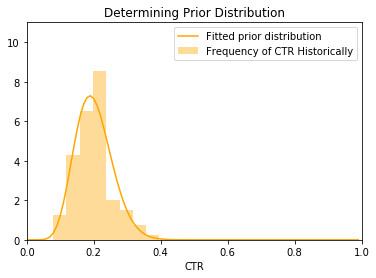

In [10]:
# Plot histogram of prior
f, ax = plt.subplots(1)
plt.plot(x, prior_distribution.pdf(x),
         label='Fitted prior distribution', c='orange')
sns.distplot(click_through_rates, kde=False, bins=8, norm_hist=True,
             label='Frequency of CTR Historically', color='orange')
ax.legend()
ax.set_xlabel("CTR")
ax.set_title("Determining Prior Distribution")
ax.set_ylim(0, 11)
ax.set_xlim(0, 1);

In [11]:
# Create a statistical model with pymc to perform MCMC
with pm.Model() as model:
    # Our prior beta distribution
    pr = pm.Beta('p', prior_a, prior_b)

    # Likelihood function with our observed dataset with the correct prior
    y = pm.Binomial('y', n=n_impressions, p=pr, observed=n_clicks)

    # Use MAP estimate (optimization) as the initial state for the MCMC
    start = pm.find_MAP()

    # Choose sampler (No U-Turn Sampler) and run
    step = pm.NUTS()
    trace = pm.sample(5000, step, start=start,
                      random_seed=42, progressbar=True)

Optimization terminated successfully.
         Current function value: 9.364837
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


100%|██████████| 5500/5500 [00:03<00:00, 1676.74it/s]


In [12]:
# Take the mean of the samples as most plausible value
most_plausible_ctr = np.mean(trace['p'])
print "Most plausible CTR based on the new ad campaign and prior: {:.1f}  %".format(most_plausible_ctr * 100)

Most plausible CTR based on the new ad campaign and prior: 33.9  %


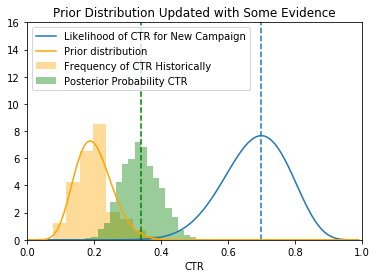

In [13]:
# Plot
f, ax = plt.subplots(1)
plt.axvline(mle, ls="--")
plt.plot(x, 40 * likelihood, label='Likelihood of CTR for New Campaign')
plt.plot(x, prior_distribution.pdf(x), label='Prior distribution', c='orange')
sns.distplot(click_through_rates, kde=False, bins=8,
             norm_hist=True, label='Frequency of CTR Historically', color='orange')
sns.distplot(trace['p'], kde=False, norm_hist=True,
             bins=20, label='Posterior Probability CTR', color='g')
plt.axvline(most_plausible_ctr, ls="--", c='g')
ax.legend()
ax.set_xlabel("CTR")
ax.set_title("Prior Distribution Updated with Some Evidence")
ax.set_ylim(0, 16)
ax.set_xlim(0, 1);

In [16]:
# In summary
print "CTR based only on the new ad campaign (MLE): {} %\n".format(ctr * 100)
print "Average past CTR: {} %".format(click_through_rates.mean() * 100)
print " - Prior: alpha = {}, beta = {}\n".format(prior_a, prior_b)
print "Most plausible CTR based on the new ad campaign and prior (MAP): {:.1f}  %".format(most_plausible_ctr * 100)

CTR based only on the new ad campaign (MLE): 70.0 %

Average past CTR: 20.0416384474 %
 - Prior: alpha = 10.4265198544, beta = 41.5819431278

Most plausible CTR based on the new ad campaign and prior (MAP): 33.9  %
